# 1. Simulating with Prognostics Models

One of the most basic of functions for models is simulation. Simulation is the process of predicting the evolution of [system's state](https://nasa.github.io/progpy/glossary.html#term-state) with time. Simulation is the foundation of prediction (see 9. Prediction). Unlike full prediction, simulation does not include uncertainty in the state and other product (e.g., [output](https://nasa.github.io/progpy/glossary.html#term-output)) representation.

The first section introduces simulating to a specific time (e.g., 3 seconds), using the `simulate_to` method. The second section introduces the concept of simulating until a threshold is met rather than a defined time, using `simulate_to_threshold`. The third section makes simulation more concrete with the introduction of [future loading](https://nasa.github.io/progpy/glossary.html#term-future-load). The sections following these introduce various advanced features that can be used in simulation.

Note: Before running this example make sure you have ProgPy installed and up to date.

## Table of Contents
* [Basic Simulation to a Time](#basic-simulation-to-a-time)
* [Simulating to Threshold](#simulating-to-threshold)
* [Future Loading](#future-loading)
    * [Piecewise Load](#piecewise-load)
    * [Moving Average](#moving-average)
    * [Gaussian Noise in Loading](#gaussian-noise-in-loading)
    * [Custom Load Profiles](#custom-load-profiles)
* [Step Size](#step-size)
    * [Basic Step Size](#basic-step-size)
    * [Dynamic Step Size](#dynamic-step-size)
    * [Custom Step Size](#custom-step-size)
* [Parameters](#parameters)
* [Noise](#noise)
* [Vectorized Simulation](#vectorized-simulation)
* [Configuring Simulation](#configuring-simulation)

<a id="basic-simulation-to-a-time"></a>

----------

## Basic Simulation to a Time 

Let's go through a basic example simulating a model to a specific point in time. In this case we are using the ThrownObject model. ThrownObject is a basic model of an object being thrown up into the air (with resistance) and returning to the ground.

First we import the model from ProgPy's models subpackage (see 3. Included Models) and create a model instance.

In [ ]:
from progpy.models import ThrownObject
m = ThrownObject()

Now we simulate this model for three seconds. To do this we use the [`simulate_to`](https://nasa.github.io/progpy/api_ref/prog_models/PrognosticModel.html#prog_models.PrognosticsModel.simulate_to) method.

In [ ]:
results = m.simulate_to(3)

It's that simple! We've simulated the model forward three seconds. Let's look in a little more detail at the returned results. 

Simulation results consists of 5 different types of information, described below:
* **times**: the time corresponding to each value.
* **[inputs](https://nasa.github.io/progpy/glossary.html#term-input)**: Control or loading applied to the system being modeled (e.g., current drawn from a battery). Input is frequently denoted by u.
* **[states](https://nasa.github.io/progpy/glossary.html#term-state)**: Internal variables (typically hidden states) used to represent the state of the system. Can be same as inputs or outputs but do not have to be. State is frequently denoted as `x`.
* **[outputs](https://nasa.github.io/progpy/glossary.html#term-output)**: Measured sensor values from a system (e.g., voltage and temperature of a battery). Can be estimated from the system state. Output is frequently denoted by `z`.
* **[event_states](https://nasa.github.io/progpy/glossary.html#term-event-state)**: Progress towards [event](https://nasa.github.io/progpy/glossary.html#term-event) occurring. Defined as a number where an event state of 0 indicates the event has occurred and 1 indicates no progress towards the event (i.e., fully healthy operation for a failure event). For a gradually occurring event (e.g., discharge) the number will progress from 1 to 0 as the event nears. In prognostics, event state is frequently called “State of Health”.

In this case, times are the start and beginning of the simulation ([0, 3]), since we have not yet told the simulator to save intermediate times. The ThrownObject model doesn't have any way of controlling or loading the object, so there are no inputs. The states are position (`x`) and velocity (`v`). This model assumes that you can measure position, so the outputs are just position (`x`). The two events for this model are `falling` (i.e., if the object is falling towards the earth) and `impact` (i.e., the object has impacted the ground). For a real prognostic model, events might be failure modes or warning thresholds.

Now let's inspect the results. First, let's plot the outputs (position)

In [ ]:
fig = results.outputs.plot()

This is a model of an object thrown in the air, so we generally expect its path to follow a parabola, but what we see above is linear. This is because there are only two points, the start (0s) and the end (3s). To see the parabola we need more points. This is where `save_freq` and `save_pts` come into play. 

`save_freq` is an argument in simulation that specifies a frequency at which you would like to save the results (e.g., 1 seconds), while `save_pts` is used to specify specific times that you would like to save the results (e.g., [1.5, 2.5, 3, 5] seconds).

Now let's repeat the simulation above with a save frequency and plot the results.

In [ ]:
results = m.simulate_to(3, save_freq=0.5)
fig = results.outputs.plot(ylabel='Position (m)')

Now we can see the start of the parabola path we expected. We dont see the full parabola because we stopped simulation at 3 seconds.

If you look at results.times, you can see that the results were saved every 0.5 seconds during simulation

In [ ]:
print(results.times)

Next, let's look at the event_states (i.e., `falling` and `impact`).

In [ ]:
fig = results.event_states.plot()

Here we see that the `falling` event state decreased linerally with time, and was approaching 0. This shows that it was nearly falling when we stopped simulation. The `impact` event state remained at 1, indicating that we had not made any progress towards impact. With this model, `impact` event state only starts decreasing as the object falls. 

Finally, let's take a look at model states. In this case the two states are position (`x`) and velocity (`v`).

In [ ]:
fig = results.states.plot()

Position will match the output exactly and velocity (`v`) decreases nearly linerally with time due to the constant pull of gravity. The slight non-linerality is due to the effects of drag.

This is a basic example of simulating to a set time. This is useful information for inspecting or analyzing the behavior of a model or the degredation of a system. There are many useful features that allow for complex simulation, described in the upcoming sections. 

Note that this is an example problem. In most cases, the system will have inputs, in which case simulation will require future loading (see Future Loading section, below), and simulation will not be until a time, but until a threshold is met. Simulating to a threshold will be described in the next section.

<a id="simulating-to-threshold"></a>

----------

## Simulating to Threshold

In the first section we introduced simulating to a set time. For most applications, users are not interested in the system evolution over a certain time period, but instead in simulating to some event of interest.

In this section we will introduce the concept of simulating until an event occurs. This section builds upon the concepts introduced in the previous section.

Just like in the previous section, we will start by preparing the ThrownObject model. 

In [ ]:
from progpy.models import ThrownObject
m = ThrownObject()

If you recall, the ThrownObject model is of an object thrown into the air. The model has two events, `impact` and `falling`. In real prognostic models, these events will likely correspond with some failure, fault, or warning threshold. That said, events can be any event of interest that a user would like to predict. 

Now let's repeat the simulation from the previous example, this time simulating until an event has occured by using the [`simulate_to_threshold`](https://nasa.github.io/progpy/api_ref/prog_models/PrognosticModel.html#prog_models.PrognosticsModel.simulate_to_threshold) method.

In [ ]:
results = m.simulate_to_threshold(save_freq=0.5)
fig = results.outputs.plot(ylabel='Position (m)')
fig = results.event_states.plot()

Note that simulation continued beyond the 3 seconds used in the first section. Instead simulation stopped at 4 seconds, at which point the `falling` event state reached 0 and the position (`x`) reached the apogee of its path.

By default, `simulate_to_threshold` simulates until the first event occurs. In this case, that's `falling` (i.e., when the object begins falling). For this model `falling` will always occur before `impact`, but for many models you won't have such a strict ordering of events. 

For users interested in when a specific event is reached, you can indicate which event(s) you'd like to simulate to using the `events` argument. For example,

In [ ]:
results = m.simulate_to_threshold(save_freq=0.5, events='impact')
fig = results.outputs.plot(ylabel='Position (m)')
fig = results.event_states.plot()

Now the model simulated past the `falling` event until the `impact` event occurred. `events` accepts a single event, or a list of events, so for models with many events you can specify a list of events where any will stop simulation.

Frequently users are interested in simulating to a threshold, only if it occurs within some horizon of interest, like a mission time or planning horizon. This is accomplished with the `horizon` keyword argument. 

For example, if we were only interested in events occuring in the next 7 seconds we could set `horizon` to 7, like below:

In [ ]:
results = m.simulate_to_threshold(save_freq=0.5, events='impact', horizon=7)
fig = results.outputs.plot(ylabel='Position (m)')
fig = results.event_states.plot()

Notice that now simulation stopped at 7 seconds, even though the event had not yet occured. If we use a horizon after the event, like 10 seconds, then simulation stops at the event.

In [ ]:
results = m.simulate_to_threshold(save_freq=0.5, events='impact', horizon=10)
fig = results.outputs.plot(ylabel='Position (m)')
fig = results.event_states.plot()

The 7 and 10 second horizon is used as an example. In most cases, the simulation horizon will be much longer. For example, you can imagine a user who's interested in prognostics for a one hour drone flight might set the horizon to a little over an hour. A user who has a month-long maintenance scheduling window might chose a horizon of one month. 

It is good practice to include a horizon with most simulations to prevent simulations continuing indefinitely for the case where the event never happens.

One final note: you can also use the print and progress options to track progress during long simulations, like below:

In [ ]:
results = m.simulate_to_threshold(save_freq=0.5, events='impact', print=True, progress=True)

For most users running this in Jupyter notebook, the output will be truncated, but it gives an idea of what would be shown when selecting these options.

In this example we specified events='impact' to indicate that simulation should stop when the specified event 'impact' is met. By default, the simulation will stop when the first of the specified events occur. If you dont specify any events, all model events will be included (in this case ['falling', 'impact']). This means that without specifying events, execution would have ended early, when the object starts falling, like below:

In [ ]:
results = m.simulate_to_threshold(save_freq=0.5, dt=0.1)
print('Last timestep: ', results.times[-1])

Note that simulation stopped at around 3.8seconds, about when the object starts falling. 

Alternately, if we would like to execute until all events have occurred we can use the `event_strategy` argument, like below:

In [ ]:
results = m.simulate_to_threshold(save_freq=0.5, dt=0.1, event_strategy='all')
print('Last timestep: ', results.times[-1])

Not the simulation stopped at around 7.9 seconds, when the last of the events occured ('impact')

This is a basic example of simulating to an event. However, this is still just an example. Most models will have some form of input or loading. Simulating these models is described in the following section. The remainder of the sections go through various features for customizing simulation further.

<a id="future-loading"></a>

----------

## Future Loading

The previous examples feature a simple ThrownObject model, which does not have any inputs. Unlike ThrownObject, most prognostics models have some sort of [input](https://nasa.github.io/progpy/glossary.html#term-input). The input is some sort of control or loading applied to the system being modeled. In this section we will describe how to simulate a model which features an input.

In this example we will be using the BatteryCircuit model from the models subpackage (see 3. Included Models). This is a simple battery discharge model where the battery is represented by an equivalent circuit.

Like the past examples, we start by importing and creating the model.

In [ ]:
from progpy.models import BatteryCircuit
m = BatteryCircuit()

You can see the battery's inputs, states, and outputs (described above) by accessing these attributes.

In [ ]:
print('outputs:', m.outputs)
print('inputs:', m.inputs)

Consulting the [model documentation](https://nasa.github.io/progpy/api_ref/prog_models/IncludedModels.html#prog_models.models.BatteryCircuit), we see that the outputs (i.e., measurable values) of the model are temperature (`t`) and voltage (`v`). The model's input is the current (`i`) drawn from the battery.

If we try to simulate as we do above (without specifying loading), it wouldn't work because the battery discharge is a function of the current (`i`) drawn from the battery. Simulation for a model like this requires that we define the future load. 

<a id="piecewise-load"></a>

----------

### Piecewise Load

For the first example, we define a piecewise loading profile using the `progpy.loading.Piecewise` class. This is one of the most common loading profiles. First we import the class from the loading subpackage

In [ ]:
from progpy.loading import Piecewise

Next, we define a loading profile. Piecewise loader takes 3 arguments: 1. the model InputContainer, 2. times and 3. loads. Each of these are explained in more detail below.

The model input container is a class for representing the input for a model. It's a class attribute for every model, and is specific to that model. It can be found at m.InputContainer. For example,

In [ ]:
m.InputContainer

InputContainers are initialized with either a dictionary or a column vector, for example:

In [ ]:
print(m.InputContainer({'i': 3}))
import numpy as np
print(m.InputContainer(np.vstack((2.3, ))))

The second and third arguments for the loading profile are times and loads. Together, the 'times' and 'loads' arguments specify what load is applied to the system at what times throughout simulation. The values in 'times' specify the ending time for each load. For example, if times were [5, 7, 10], then the first load would apply until t=5, then the second load would apply for 2 seconds, following by the third load for 3 more seconds. 

Loads are a dictionary of arrays, where the keys of the dictionary are the inputs to the model (for a battery, just current `i`), and the values in the array are the value at each time in times. If the loads array is one longer than times, then the last value is the "default load", i.e., the load that will be applied after the last time has passed.

For example, we might define this load profile for our battery.

In [ ]:
loading = Piecewise(
        InputContainer=m.InputContainer,
        times=[600, 900, 1800, 3000],
        values={'i': [2, 1, 4, 2, 3]})

In this case, the current drawn (`i`) is 2 amps until t is 600 seconds, then it is 1 for the next 300 seconds (until 900 seconds), etc. The "default load" is 3, meaning that after the last time has passed (3000 seconds) a current of 3 will be drawn. 

Now that we have this load profile, let's run a simulation with our model

In [ ]:
results = m.simulate_to_threshold(loading, save_freq=100)

Let's take a look at the inputs to the model

In [ ]:
fig = results.inputs.plot(ylabel="Current Draw (amps)")

See above that the load profile is piecewise, matching the profile we defined above.

Plotting the outputs, you can see jumps in the voltage levels as the current changes.

In [ ]:
fig = results.outputs.plot(compact=False)

In this example we simulated to threshold, loading the system using a simple piecewise load profile. This is the most common load profile and will probably work for most cases.

<a id="moving-average"></a>

----------

### Moving Average

Another common loading scheme is the moving-average load. This loading scheme assumes that the load will continue like it's seen in the past. This is useful when you don't know the exact load, but you expect it to be consistent.

Like with Piecewise loading, the first step it to import the loading class. In this case, `progpy.loading.MovingAverage`

In [ ]:
from progpy.loading import MovingAverage

Next we create the moving average loading object, passing in the InputContainer

In [ ]:
loading = MovingAverage(m.InputContainer)

The moving average load estimator requires an additional step, sending the observed load. This is done using the add_load method. Let's load it up with some observed current draws. 

In [ ]:
measured_loads = [4, 4.5, 4.0, 4, 2.1, 1.8, 1.99, 2.0, 2.01, 1.89, 1.92, 2.01, 2.1, 2.2]
    
for load in measured_loads:
    loading.add_load({'i': load})

In practice the add_load method should be called whenever there's new input (i.e., load) information. The MovingAverage load estimator averages over a window of elements, configurable at construction using the window argument (e.g., MovingAverage(m.InputContainer, window=12))

Now the configured load estimator can be used in simulation. 

In [ ]:
results = m.simulate_to_threshold(loading, save_freq=100)

Now let's take a look at the resulting input current.

In [ ]:
fig = results.inputs.plot()

Note that the loading is a constant around 2, this is because the larger loads (~4 amps) are outside of the averaging window. Here are the resulting outputs

In [ ]:
fig = results.outputs.plot(compact=False)

The voltage and temperature curves are much cleaner. They don't have the jumps present in the piecewise loading example. This is due to the constant loading.

In this example we simulated to threshold, loading the system using a constant load profile calculated using the moving average load estimator. This load estimator needs to be updated with the add_load method whenever new loading data is available. 

<a id="gaussian-noise-in-loading"></a>

----------

### Gaussian Noise in Loading

Typically, users have an idea of what loading will look like, but there is some uncertainty. Future load estimates are hardly ever known exactly. This is where load wrappers like the `progpy.loading.GaussianNoiseLoadWrapper` come into play. The GaussianNoiseLoadWrapper wraps around another load profile, adding a random amount of noise, sampled from a Gaussian distribution, at each step. This will show some variability in simulation, but this becomes more important in prediction (see 9. Prediction).

In this example we will repeat the Piecewise load example, this time using the GaussianNoiseLoadWrapper to represent our uncertainty in our future load estimate. 

First we will import the necessary classes and construct the Piecewise load estimation just as in the previous example.

In [ ]:
from progpy.loading import Piecewise, GaussianNoiseLoadWrapper
loading = Piecewise(
        InputContainer=m.InputContainer,
        times=[600, 900, 1800, 3000],
        values={'i': [2, 1, 4, 2, 3]})

Next we will wrap this loading object in our Gaussian noise load wrapper

In [ ]:
loading_with_noise = GaussianNoiseLoadWrapper(loading, 0.2)

In this case we're adding Gaussian noise with a standard deviation of 0.2 to the result of the previous load estimator.

Now let's simulate and look at the input profile.

In [ ]:
results = m.simulate_to_threshold(loading_with_noise, save_freq=100)
fig = results.inputs.plot()

Note the loading profile follows the piecewise shape, but with noise. If you run it again, you would get a slightly different result.

In [ ]:
results = m.simulate_to_threshold(loading_with_noise, save_freq=100)
fig = results.inputs.plot()

Here are the corresponding outputs.

In [ ]:
fig = results.outputs.plot(compact=False)

Note that the noise in input can be seen in the resulting output plots.

The seed can be set in creation of the GaussianNoiseLoadWrapper to ensure repeatable results, for example.

In [ ]:
loading_with_noise = GaussianNoiseLoadWrapper(loading, 0.2, seed=2000)
results = m.simulate_to_threshold(loading_with_noise, save_freq=100)
fig = results.inputs.plot()

loading_with_noise = GaussianNoiseLoadWrapper(loading, 0.2, seed=2000)
results = m.simulate_to_threshold(loading_with_noise, save_freq=100)
fig = results.inputs.plot()

The load profiles in the two examples above are identical because they share the same random seed.

In this section we introduced the concept of NoiseWrappers and how they are used to represent uncertainty in future loading. This concept is especially important when used with prediction (see 9. Prediction). A GaussianNoiseLoadWrapper was used with a Piecewise loading profile to demonstrate it, but NoiseWrappers can be applied to any loading object or function, including the advanced profiles introduced in the next section.

<a id="custom-load-profiles"></a>

----------

### Custom Load Profiles

For most applications, the standard load estimation classes can be used to represent a user's expectation of future loading. However, there are some cases where load is some complex combination of time and state that cannot be represented by these classes. This section briefly describes a few of these cases. 

The first example is similar to the last one, in that there is Gaussian noise added to some underlying load profile. In this case the magnitude of noise increases linearly with time. This is an important example, as it allows us to represent a case where loading further out in time has more uncertainty (i.e., is less well known). This is common for many prognostic use-cases.

Custom load profiles can be represented either as a function (t, x=None) -> u, where t is time, x is state, and u is input, or as a class which implements the __call__ method with the same profile as the function.

In this case we will use the first method (i.e., the function). We will define a function that will use a defined slope (derivative of standard deviation with time).

In [ ]:
from numpy.random import normal
base_load = 2  # Base load (amps)
std_slope = 1e-4  # Derivative of standard deviation with time
def loading(t, x=None):
    std = std_slope * t
    return m.InputContainer({'i': normal(base_load, std)})

Note that the above code is specifically for a battery, but it could be generalized to any system.

Now let's simulate and look at the input profile.

In [ ]:
results = m.simulate_to_threshold(loading, save_freq=100)
fig = results.inputs.plot()

Note how the noise in the input signal increases with time. Since this is a random process, if you were to run this again you would get a different result.

Here is the corresponding output. Note you can see the effects of the increasingly erratic input in the voltage curve.

In [ ]:
fig = results.outputs.plot(compact=False)

In the final example we will define a loading profile that considers state. In this example, we're simulating a scenario where loads are removed (i.e., turned off) when discharge event state (i.e., SOC) reaches 0.25. This emulates a "low power mode" often employed in battery-powered electronics.

For simplicity the underlying load will be constant, but this same approach could be applied to more complex profiles, and noise can be added on top using a NoiseWrapper.

In [ ]:
normal_load = m.InputContainer({'i': 2.7})
low_power_load = m.InputContainer({'i': 1.9})

def loading(t, x=None):
    if x is not None:
        # State is provided
        soc = m.event_state(x)['EOD']
        return normal_load if soc > 0.25 else low_power_load
    return normal_load

Note that the above example checks if x is not None. For some models, for the first timestep, state may be None (because state hasn't yet been calculated).

Now let's use this in simulation and take a look at the loading profile.

In [ ]:
results = m.simulate_to_threshold(loading, save_freq=100)
fig = results.inputs.plot()

Here, as expected, load is at normal level for most of the time, then falls to low power mode towards the end of discharge.

Let's look at the corresponding outputs.

In [ ]:
fig = results.outputs.plot(compact=False)

Notice the jump in voltage at the point where the load changed. Low power mode extended the life of the battery.

In this section we show how to make custom loading profiles. Most applications can use the standard load classes, but some may require creating complex custom load profiles using this feature.

<a id="step-size"></a>

----------

## Step Size

The next configurable parameter in simulation is the step size, or `dt`. This is the size of the step taken from one step to the next when simulating. Smaller step sizes will usually more accurately simulate state evolution, but at a computational cost. Conversely, some models can become unstable at large step sizes. Choosing the correct step size is important to the success of a simulation or prediction.

In this section we will introduce the concept of setting simulation step size (`dt`) and discuss some considerations when selecting step sizes.

For this section we will use the `progpy.models.ThrownObject model` (see 3. Included models), imported and created below.

In [ ]:
from progpy.models import ThrownObject
m = ThrownObject()

<a id="basic-step-size"></a>

----------

### Basic Step Size

To set step size, set the dt parameter in the `simulate_to` or `simulate_to_threshold` methods. In this example we will use a large and small step size and compare the results.

First, let's simulate with a large step size, saving the result at every step.

In [ ]:
results = m.simulate_to_threshold(
    events='impact',
    dt=2.5,
    save_freq=2.5)
fig = results.outputs.plot(ylabel='Position (m)')

Note that the parabola above is jagged. Also note that the estimated time of impact is around 10 seconds and the maximum height is a little over 120 meters. 

Now let's run the simulation again with a smaller step size.

In [ ]:
results = m.simulate_to_threshold(
    events='impact',
    dt=0.25,
    save_freq=0.25)
fig = results.outputs.plot(ylabel='Position (m)')

Not only is the curve much smoother with a smaller step size, but the results are significantly different. Now the time of impact is closer to 8 seconds and maximum height closer to 80 meters.

All simulations are approximations. The example with the larger step size accumulates more error in integration. The second example (with a smaller step size) is more accurate to the actual model behavior.

Now let's decrease the step size even more

In [ ]:
results = m.simulate_to_threshold(
    events='impact',
    dt=0.05,
    save_freq=0.05)
fig = results.outputs.plot(ylabel='Position (m)')

The resulting output is different than the 0.25 second step size run, but not by much. What you see here is the diminishing returns in decreasing step size.

The smaller the step size, the more computational resources required to simulate it. This doesn't matter as much for simulating this simple model over a short horizon, but becomes very important when performing prediction (see 9. Prediction), using a complex model with a long horizon, or when operating in a computationally constrained environment (e.g., embedded).

<a id="dynamic-step-size"></a>

----------

### Dynamic Step Size

The last section introduced step size and showed how changing the step size effects the simulation results. In the last example step size (`dt`) and `save_freq` were the same, meaning each point was captured exactly. This is not always the case, for example in the case below. 

In [ ]:
results = m.simulate_to_threshold(
    events='impact',
    dt=1,
    save_freq=1.5)
print('Times saved: ', results.times)

With a `save_freq` of 1.5 seconds you might expect the times saved to be 0, 1.5, 3, 4.5, ..., but that's not the case. This is because the timestep is 1 second, so the simulation never stops near 1.5 seconds to record it. 'auto' stepsize can help with this.

To use 'auto' stepsize set `dt` to a tuple of ('auto', MAX) where MAX is replaced with the maximum allowable stepsize.

In [ ]:
results = m.simulate_to_threshold(
    events='impact',
    dt=('auto', 1),
    save_freq=1.5)
print('Times saved: ', results.times)

We repeated the simulation using automatic step size with a maximum step size of 1. The result was that the times where state was saved matched what was requested exactly. This is important for simulations with large step sizes where there are specific times that must be captured.

Also note that automatic step size doesn't just adjust for `save_freq`. It will also adjust to meet `save_pts` and any transition points in a Piecewise loading profile.

<a id="custom-step-size"></a>

----------

### Custom Step Size

There are times when an advanced user would like more flexibility in selecting step sizes. This can be used to adjust step size dynamically close to events or times of interest. In some models, there are complex behaviors during certain parts of the life of the system that require more precise simulation. For example, the knee point in the voltage profile for a discharged battery. This can be done by providing a function (t, x)->dt instead of a scalar `dt`. 

For example, if a user wanted to reduce the step size closer to impact, they could do so like this:

In [ ]:
def next_time(t, x):
    # In this example dt is a function of state. Uses a dt of 1 until impact event state 0.25, then 0.25
    event_state = m.event_state(x)
    if event_state['impact'] < 0.25:
        return 0.25
    return 1

results=m.simulate_to_threshold(dt=next_time, save_freq= 0.25, events='impact')

print(results.times)

Note that after 8 seconds the step size decreased to 0.25 seconds, as expected.

<a id="parameters"></a>

----------

## Parameters

All the previous sections used a model with default settings. This is hardly ever the case. A model will have to be configured to represent the actual system. For example, the BatteryCircuit default parameters are for a 18650 battery tested in NASA's SHARP lab. If you're using the model for a system other than that one battery, you will need to update the parameters.

The parameters available are specific to the system in question. See 3. Included Models for a more detailed description of these. For example, for the BatteryCircuit model, parameters include battery capacity, internal resistance, and other electrical characteristics.

In this section we will adjust the parameters for the ThrownObject Model, observing how that changes system behavior.

In [ ]:
from progpy.models import ThrownObject
m = ThrownObject()

Parameters can be accessed using the `parameters` attribute. For a ThrownObject, here are the parameters:

In [ ]:
print(m.parameters)

Ignoring process and measurement noise for now (that will be described in the next section) and the lumped_parameter (which will be described in 4. Creating new prognostic models), the parameters of interest here are described below:

* **thrower_height**: The height of the thrower in meters, and therefore the initial height of the thrown object
* **throwing_speed**: The speed at which the ball is thrown vertically (in m/s)
* **g**: Acceleration due to gravity (m/s^2)
* **rho**: Air density (affects drag)
* **A**: Cross-sectional area of the object (affects drag)
* **m**: Mass of the object (affects drag)
* **cd**: Coefficient of drag of the object (affects drag)

Let's try simulating the path of the object with different throwing speeds.

In [ ]:
results1 = m.simulate_to_threshold(events='impact', dt=0.1, save_freq=0.1)
fig = results1.outputs.plot(title='default')

m['throwing_speed'] = 10
results2 = m.simulate_to_threshold(events='impact', dt=0.1, save_freq=0.1)
fig = results2.outputs.plot(title='slow')

m['throwing_speed'] = 80
results3 = m.simulate_to_threshold(events='impact', dt=0.1, save_freq=0.1)
fig = results3.outputs.plot(title='fast')

You can also set parameters as keyword arguments when instantiating the model, like below. 

In [ ]:
m_e = ThrownObject(g=-9.81)  # Earth gravity
results_earth = m_e.simulate_to_threshold(events='impact', dt=0.1, save_freq=0.1)
fig = results_earth.outputs.plot(title='Earth')

m_j = ThrownObject(g=-24.79)  # Jupiter gravity
results_jupiter = m_j.simulate_to_threshold(events='impact', dt=0.1, save_freq=0.1)
fig = results_jupiter.outputs.plot(title='Jupiter')

Model parameters are used to configure a model to accurately describe the system of interest.

For a simple system like the ThrownObject, model parameters are simple and measurable. For most systems, there are many parameters that are difficult to estimate. For these, parameter estimation comes into play. See 2. Parameter Estimation for more details

<a id="noise"></a>

----------

## Noise

It is impossible to have absolute knowledge of future states due to uncertainties in the system. To account for this, we can incorporate uncertainty into a model through the following forms:

* __Process Noise__: Noise representing uncertainty in the model transition (e.g., model or model configuration uncertainty, uncertainty from simplifying assumptions). Applied during state transition.
* __Measurement Noise__: Noise representing uncertainty in the measurement process (e.g., sensor sensitivity, sensor misalignments, environmental effects). Applied during estimation of outputs from states.
* __Future Loading Noise__: Noise representing uncertainty in the future loading estimates (e.g., uncertainty from incomplete knowledge of future loading). Responsibility of user to apply in supplied future loading method.

Other types of uncertainty will be introduced in [08_Prediction](08_Prediction.ipynb).

In this section, we will be examining multiple approaches to adding process noise and measurement noise. For an example that adds future loading noise, please refer to the `GaussianNoiseLoadWrapper` in the [Gaussian Noise in Loading](#gaussian-noise-in-loading) section.

We will start by importing the ThrownObject model for simulation and matplotlib for graphing.

In [1]:
from progpy.models import ThrownObject
import matplotlib.pyplot as plt

We will now define the configuration of the simulation and a helper function to print the results. We will not be passing in a future load since the ThrownObject model has no inputs and we cannot load the system (i.e., affect it once it's in the air).

In [2]:
config = {
    'events': 'impact',
    'dt': 0.005,
    'save_freq': 0.5,
}

def print_results(simulated_results):
    print('states:')
    for (t, x) in zip(simulated_results.times, simulated_results.states):
        print('\t{:.2f}s: {}'.format(t, x))

    print('outputs:')
    for (t, x) in zip(simulated_results.times, simulated_results.outputs):
        print('\t{:.2f}s: {}'.format(t, x))

    # The simulation stopped at impact, so the last element of times is the impact time
    print('\nimpact time: {:.2f}s'.format(simulated_results.times[-1]))

Let's start with an example with no noise.

Simulation without noise
states:
	0.00s: {'x': np.float64(1.83), 'v': np.float64(40.0)}
	0.50s: {'x': np.float64(20.35092591060207), 'v': np.float64(34.07855124289541)}
	1.00s: {'x': np.float64(35.98598359025924), 'v': np.float64(28.448770474404466)}
	1.50s: {'x': np.float64(48.9812214219364), 'v': np.float64(22.99846684410669)}
	2.00s: {'x': np.float64(59.18332628263409), 'v': np.float64(17.784029484245163)}
	2.50s: {'x': np.float64(66.81357749367159), 'v': np.float64(12.705288070826589)}
	3.00s: {'x': np.float64(71.92955924357045), 'v': np.float64(7.721366562656726)}
	3.50s: {'x': np.float64(74.56918342157253), 'v': np.float64(2.794268972436784)}
	4.00s: {'x': np.float64(74.75187498447991), 'v': np.float64(-2.1113986020335997)}
	4.50s: {'x': np.float64(72.48494840830797), 'v': np.float64(-6.999730906671477)}
	5.00s: {'x': np.float64(67.78481823843082), 'v': np.float64(-11.837967035954334)}
	5.50s: {'x': np.float64(60.68492405986194), 'v': np.float64(-16.59252129293879)}
	6.00s: {'x':

/Users/michellely/Documents/GitHub/progpy/src/progpy/exceptions.py:20: UserWarning: Behavior of SimResult.plot() will change with version 1.6. New behavior will match that of a pandas data frame.
  warn(msg, *args, **kwargs)


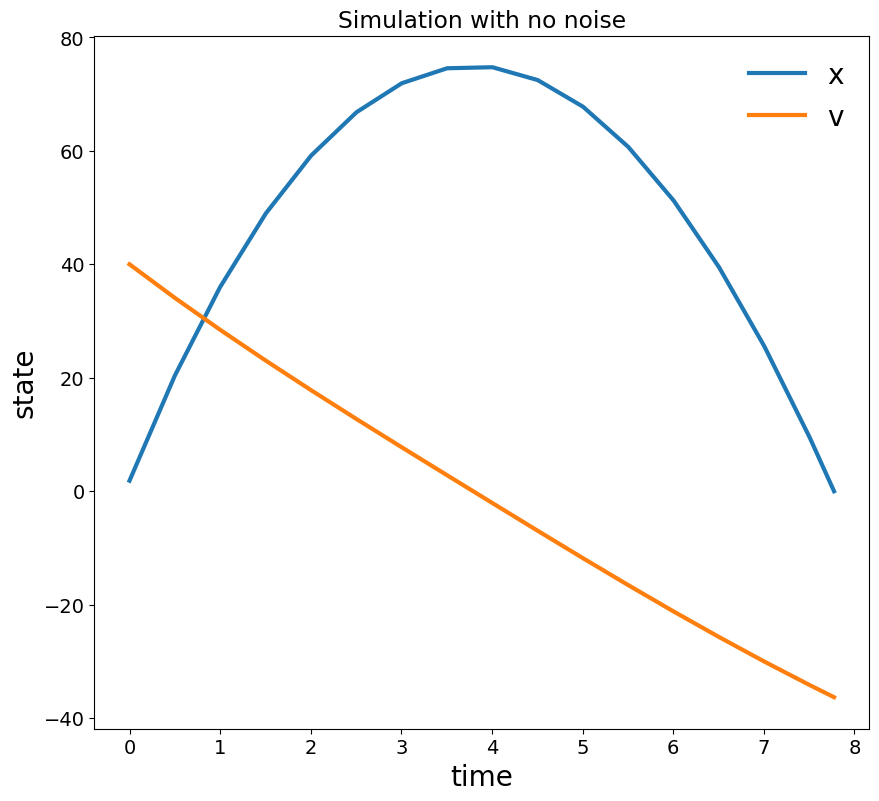

In [3]:
m = ThrownObject(process_noise=False)
print('Simulation without noise')
simulated_results = m.simulate_to_threshold(**config)

print_results(simulated_results)
simulated_results.states.plot()
plt.title('Simulation with no noise')
plt.show()

Let's save the simulated results from this example into the variable `no_noise_simulation` to use as a comparison reference to the next few examples showing simulations with noise.

In [ ]:
no_noise_simulation = simulated_results

We'll also define a helper function to display the overlay of the two simulations.

In [ ]:
def print_comparison_plot(no_noise_simulation, simulated_results):
    plt.figure(figsize=(10,8))
    
    no_noise_x = [state['x'] for state in no_noise_simulation.states]
    no_noise_v = [state['v'] for state in no_noise_simulation.states]
    plt.plot(no_noise_simulation.times, no_noise_x, label='No noise (x)', color='tab:blue', linestyle='dashed')
    plt.plot(no_noise_simulation.times, no_noise_v, label='No noise (v)', color='tab:orange', linestyle='dashed')
    
    noise_x = [state['x'] for state in simulated_results.states]
    noise_v = [state['v'] for state in simulated_results.states]
    plt.plot(simulated_results.times, noise_x, label='Noise (x)', color='tab:blue')
    plt.plot(simulated_results.times, noise_v, label='Noise (v)', color='tab:orange')
    
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("state")

Here is an example of a simulation with normal (i.e., gaussian) process noise with a standard deviation of 25 applied to every state. Even though this standard deviation is quite high, we'll notice the curves aren't dramatically different due to the small step size. Every step noise is resampled so the noise added on a single step may be large but cancelled out over many steps.

In [ ]:
process_noise = 25

m = ThrownObject(process_noise=process_noise)
print('Simulation with process noise')
simulated_results = m.simulate_to_threshold(**config)

print_results(simulated_results)
print_comparison_plot(no_noise_simulation, simulated_results)
plt.title("Simulation with no noise vs. process noise")
plt.show()

We can also specify different amounts of noise on different states. This is an example of a simulation with more process noise on position than velocity. Here you should see a smooth curve for the velocity and a noisy curve for position.

In [ ]:
process_noise = {'x': 30, 'v': 1}

m = ThrownObject(process_noise=process_noise)
print('Simulation with more process noise on position than velocity')
simulated_results = m.simulate_to_threshold(**config)

print_results(simulated_results)
print_comparison_plot(no_noise_simulation, simulated_results)
plt.title('Simulation with no noise vs. more process noise on position than velocity')
plt.show()

We can also define the shape of the noise to be uniform or triangular instead of normal. This example demonstrates a uniform process noise distribution.

In [ ]:
process_noise = {'x': 30, 'v': 1}
process_noise_dist = 'uniform'
model_config = {'process_noise_dist': process_noise_dist,
                'process_noise': process_noise}

m = ThrownObject(**model_config)
print('Simulation with uniform process noise distribution')
simulated_results = m.simulate_to_threshold(**config)

print_results(simulated_results)
display_comparison_plot(no_noise_simulation, simulated_results)
plt.title('Simulation with no noise vs. uniform process noise distribution')
plt.show()

The above examples all focused on process noise. We can also use measurement noise and apply a noise distribution. Note that the outputs are different than the states since measurement noise is applied during the estimation of the outputs from the states. This means we will need to plot the x values for the simulation from the outputs rather than the states.

In [ ]:
measurement_noise = {'x': 10}
measurement_noise_dist = 'triangular'
model_config = {'measurement_noise_dist': measurement_noise_dist,
                'measurement_noise': measurement_noise}

m = ThrownObject(**model_config)
print('Simulation with triangular measurement noise distribution')
simulated_results = m.simulate_to_threshold(**config)

print_results(simulated_results)

plt.figure(figsize=(10,8))

no_noise_x = [state['x'] for state in no_noise_simulation.states]
no_noise_v = [state['v'] for state in no_noise_simulation.states]
plt.plot(no_noise_simulation.times, no_noise_x, label='No noise (x)', color='tab:blue', linestyle='dashed')
plt.plot(no_noise_simulation.times, no_noise_v, label='No noise (v)', color='tab:orange', linestyle='dashed')

noise_x = [state['x'] for state in simulated_results.outputs]
noise_v = [state['v'] for state in simulated_results.states]
plt.plot(simulated_results.times, noise_x, label='Noise (x)', color='tab:blue')
plt.plot(simulated_results.times, noise_v, label='Noise (v)', color='tab:orange')

plt.legend()
plt.xlabel("time")
plt.ylabel("state")    
plt.title('Simulation with no noise vs. triangular measurement noise distribution')
plt.show()

Let's now examine proportional noise, which can be used to do custom or more complex noise distributions. In this example, we will define a helper function `apply_proportional_process_noise`, which will add proportional noise to v and add more variation when the object is going faster.

If we wanted to apply noise in a replicable manner, we could set the numpy random seed to a fixed value `numpy.random.seed(42)`

In [ ]:
def apply_proportional_process_noise(self, x, dt=1):
    x['v'] -= dt*0.5*x['v']
    return x

model_config = {'process_noise': apply_proportional_process_noise}

m = ThrownObject(**model_config)
print('Simulation with proportional noise on velocity')
simulated_results = m.simulate_to_threshold(**config)

print_results(simulated_results)
print_comparison_plot(no_noise_simulation, simulated_results)
plt.title('Simulation with no noise vs. proportional noise on velocity')
plt.show()

<a id="vectorized-simulation"></a>

----------

## Vectorized Simulation

**A version of this section will be added in release v1.8**

<a id="configuring-simulation"></a>

----------

## Configuring Simulation

**A version of this notebook will be added in release v1.8, including:**
* t0, x
* integration_method